## Run model and collect predictions on BABILong

In [1]:
import os
os.chdir('..')

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import datasets
from tqdm.auto import tqdm
import pandas as pd
import time
import json

from pathlib import Path

from babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from babilong.babilong_utils import compare_answers

In [27]:
!ls ../../kuratov/models/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Llama-2-7b-chat-hf	      Yarn-Mistral-7b-128k   gigaseek-20b-32k-pretrain
Llama-2-7b-chat-hf-tokenizer  c4ai-command-r-v01     gigaseek-20b-8k-pretrain
Meta-Llama-3.1-8B-Instruct    gigar-7b-32k-pretrain
Mixtral-8x22B-Instruct-v0.1   gigar-7b-8k-pretrain


In [3]:
model_name = 'gigar-8k'
model_path = '../../kuratov/models/gigar-7b-8k-pretrain/'
dtype = torch.bfloat16
device = 'cpu'
max_length = 16000

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, legacy=True)

In [12]:
model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True,
                                             device_map=device, torch_dtype=dtype,
                                            #  attn_implementation='flash_attention_2'
                                             )
model = model.eval()

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
generate_kwargs = {
    'num_beams': 1,
    'do_sample': False,
    'temperature': None,
    'top_p': None,
    'top_k': None,
}

In [14]:
# tasks = ['qa1', 'qa2','qa3', 'qa4', 'qa5'] #, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
# split_names = ['0k', '1k', '2k', '4k', '8k', '16k', '32k']#, '64k']#, '128k']

tasks = ['qa1'] #, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
split_names = ['0k', '1k', '2k', '4k']#, '64k']#, '128k']

In [15]:
TEMPLATE = '{instruction}\n{examples}\n{post_prompt}\nContext: {context}\n\nQuestion: {question}'
import re

def clean_examples(initial_examples):
    examples = re.sub('<example>', 'Example:', initial_examples)
    examples = re.sub('</example>', '', examples)
    return examples

def get_formatted_input(context, question, examples, instruction, post_prompt, template=TEMPLATE):
    # pre_prompt - general instruction
    # examples - in-context examples
    # post_prompt - any additional instructions after examples
    # context - text to use for qa
    # question - question to answer based on context
    cleaned_examples = clean_examples(examples)
    
    formatted_input = template.format(instruction=instruction, examples=cleaned_examples, 
                                        post_prompt=post_prompt, context=context, question=question)
    return formatted_input.strip()

### Run

In [ ]:
output[0]

In [16]:
with torch.no_grad():
    output = model.generate(**input, max_length=sample_length+25, **generate_kwargs)

In [25]:
out = output[0][input['input_ids'].shape[1] - 100:]
out = tokenizer.decode(out, skip_special_tokens=True).strip()

In [26]:
out

'Context: Mary moved to the hallway. Daniel travelled to the office.\n\nQuestion: Where is Mary?\n\nAnswer: Mary is in the hallway.\n\nQuestion: Where is Daniel?\n\nAnswer: Daniel is'

In [10]:
# zero-shot
for task in tqdm(tasks, desc='tasks'):
    prompt_cfg = {
        'instruction': '',
        'examples': '', 
        'post_prompt': '',
        'template': TEMPLATE,
    }
    
    prompt_name = [f'{k}_no' if len(prompt_cfg[k]) == 0 else f'{k}_yes' for k in prompt_cfg if k != 'template']
    prompt_name = '_'.join(prompt_name)
    for split_name in tqdm(split_names, desc='lengths'):
        # data = datasets.load_dataset("booydar/babilong", split_name)
        # task_data = data[task].select(range(100))
        data_path = f"/home/jovyan/rmt/babilong/data/babilong-hf/tasks_1000/data/{task}/{split_name}.json"
        with open(data_path, 'r') as f:
            data = json.load(f)

        task_data = [data[i] for i in range(200, 300)]

        outfile = Path(f'./babilong_evals_s3/{model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)
        cfg_file = f'./babilong_evals_s3/{model_name}/{task}_{split_name}_{prompt_name}.json'
        json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

        df = pd.DataFrame({'target': [], 'output': []})

        for sample in tqdm(task_data):
            target = sample['target']
            context = sample['input']
            question = sample['question']

            input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                             prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                             template=TEMPLATE)
            input = tokenizer(input_text, return_tensors="pt", add_special_tokens=True).to(model.device)
            sample_length = input['input_ids'].shape[1]
            1/0
            with torch.no_grad():
                output = model.generate(**input, max_length=sample_length+25, **generate_kwargs)
            output = output[0][input['input_ids'].shape[1]:]
            output = tokenizer.decode(output, skip_special_tokens=True).strip()

            df.loc[len(df)] = [target, output]
            df.to_csv(outfile)

tasks:   0%|          | 0/1 [00:00<?, ?it/s]

lengths:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

ZeroDivisionError: division by zero

In [8]:
# few-shot
for task in tqdm(tasks, desc='tasks'):
    prompt_cfg = {
        'instruction': DEFAULT_PROMPTS[task]['instruction'],
        'examples': DEFAULT_PROMPTS[task]['examples'], 
        'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'],
        'template': TEMPLATE,
    }
    
    prompt_name = [f'{k}_no' if len(prompt_cfg[k]) == 0 else f'{k}_yes' for k in prompt_cfg if k != 'template']
    prompt_name = '_'.join(prompt_name)
    for split_name in tqdm(split_names, desc='lengths'):
        # data = datasets.load_dataset("booydar/babilong", split_name)
        # task_data = data[task].select(range(100))
        data_path = f"/home/jovyan/rmt/babilong/data/babilong-hf/tasks_1000/data/{task}/{split_name}.json"
        with open(data_path, 'r') as f:
            data = json.load(f)

        task_data = [data[i] for i in range(200, 300)]

        outfile = Path(f'./babilong_evals_s3/{model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)
        cfg_file = f'./babilong_evals_s3/{model_name}/{task}_{split_name}_{prompt_name}.json'
        json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

        df = pd.DataFrame({'target': [], 'output': []})

        for sample in tqdm(task_data):
            target = sample['target']
            context = sample['input']
            question = sample['question']

            input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                             prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                             template=TEMPLATE)
            # 1/0

            input = tokenizer(input_text, return_tensors="pt", add_special_tokens=True).to(model.device)
            sample_length = input['input_ids'].shape[1]
            with torch.no_grad():
                output = model.generate(**input, max_length=sample_length+25, **generate_kwargs)
            output = output[0][input['input_ids'].shape[1]:]
            output = tokenizer.decode(output, skip_special_tokens=True).strip()

            df.loc[len(df)] = [target, output]
            df.to_csv(outfile)

tasks:   0%|          | 0/1 [00:00<?, ?it/s]




































































































100%|██████████| 100/100 [00:40<00:00,  2.48it/s]





































































































100%|██████████| 100/100 [00:49<00:00,  2.04it/s]





































































































100%|██████████| 100/100 [01:05<00:00,  1.53it/s]



Token indices sequence length is longer than the specified maximum sequence length for this model (4243 > 4096). Running this sequence through the model will result in indexing errors


































































































tasks: 100%|██████████| 1/1 [04:15<00:00, 255.18s/it]


## Evaluate result

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

# import os
# os.chdir('..')

In [12]:
results_folder = './babilong_evals_s3'

In [13]:
# tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
# lengths = ['0k', '1k', '2k', '4k', '8k', '16k']#, '32k']
# tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
# lengths = ['0k', '1k', '2k', '4k', '8k', '16k']#, '32k']
tasks = ['qa2']
lengths = ['0k', '1k', '2k', '4k']#, '32k']

No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_16k_instruction_no_examples_no_post_prompt_no.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa5_16k_instruction_no_examples_no_post_prompt_no.csv


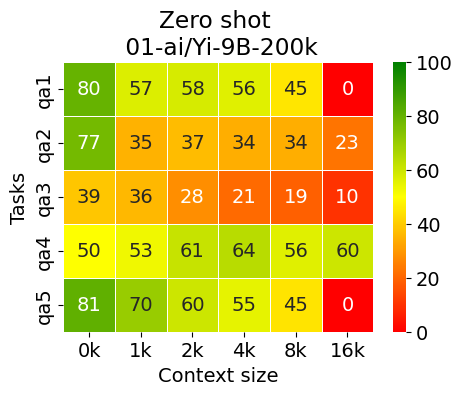

In [14]:
prompt_name = 'instruction_no_examples_no_post_prompt_no'
accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Zero shot \n {model_name}')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()

No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_0k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_1k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_2k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_4k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_8k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_16k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa2_0k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa2_1k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa2_2k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-

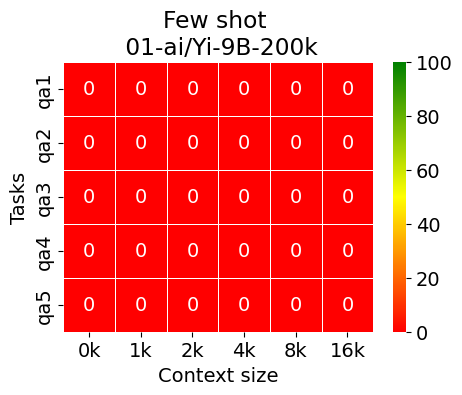

In [15]:
prompt_name = 'instruction_yes_examples_yes_post_prompt_yes'

accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Few shot \n {model_name}')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()

### qa4 for comparison

In [9]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

# import os
# os.chdir('..')

In [10]:
results_folder = './babilong_evals_s3'

In [11]:
# tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
# lengths = ['0k', '1k', '2k', '4k', '8k', '16k']#, '32k']
tasks = ['qa2']
lengths = ['0k', '1k', '2k', '4k']#, '32k']

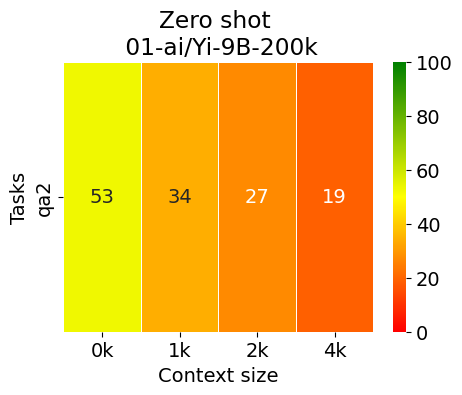

In [12]:
prompt_name = 'instruction_no_examples_no_post_prompt_no'
accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Zero shot \n {model_name}')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()

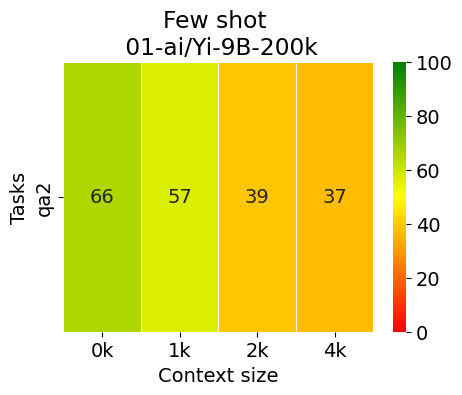

In [13]:
prompt_name = 'instruction_yes_examples_yes_post_prompt_yes'

accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Few shot \n {model_name}')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()